# Data exploration

Let's take a look at the data we got from the Wikipedia CirrusSearch dump. The gzip 'content' file is 34 GB on disk, so I don't think that we want to try decompressing and reading the whole thing into memory unless we have to. Let's see if we can stream the data from the gzip archive and take a look at what we have.

**TLDR**
1. CirrusSearch 'content' dump has text and title keys
2. Reading from decompressed JSON is twice and fast as reading from the gzip archive

## 1. Setup

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

# Standard imports
import json
import time
from gzip import GzipFile

# PyPI imports
import mwparserfromhell
import matplotlib.pyplot as plt # type: ignore

# Internal imports
import functions.helper as helper_funcs

Working directory: /mnt/arkk/opensearch/semantic_search


In [2]:
sample_records=5
gzip_data_file_path='./data/raw_data/enwiki-20240930-cirrussearch-content.json.gz'
json_data_file_path='./data/raw_data/enwiki-20240930-cirrussearch-content.json'

run_rate_experiments=True
run_parse_experiments=True


## 2. Load data sample

In [3]:
# Load a few records for inspection
file_stream=GzipFile(gzip_data_file_path)
records = []

for i in range(sample_records):

    line=next(file_stream)
    record=json.loads(line)
    records.append(record)

print(f'Loaded {len(records)} records from gzip archive.')
print(f'Record is: {type(records[0])}')

print(f'\nRecord 0 contains:')

for key, value in records[0].items():
    print(f' {key}: {value}')


Loaded 5 records from gzip archive.
Record is: <class 'dict'>

Record 0 contains:
 index: {'_type': '_doc', '_id': '1000'}


OK, looks like the first line in the file is just some metadata. Let's look at the second record.

In [4]:
print(f'\nRecord 1 keys:')

for key in records[1].keys():
    print(f' {key}')


Record 1 keys:
 version
 wiki
 page_id
 namespace
 namespace_text
 title
 timestamp
 create_timestamp
 redirect
 category
 external_link
 outgoing_link
 template
 text
 source_text
 text_bytes
 content_model
 coordinates
 language
 heading
 opening_text
 auxiliary_text
 defaultsort
 file_text
 display_title
 wikibase_item
 popularity_score
 weighted_tags


More like what we were expecting. We have keys for title, text, timestamp, language, even popularity score? Didn't know Wikipedia had that. Here is the title and some text from the first record:

In [5]:
start_text=' '.join(records[1]['text'].split(' ')[:100])
end_text=' '.join(records[1]['text'].split(' ')[-100:])

print(f"Title: {records[1]['title']}")
print(f"Text:\n{start_text}\n...\n{end_text}")

Title: Hercule Poirot
Text:
Hercule Poirot (UK: /ˈɛərkjuːl ˈpwɑːroʊ/, US: /hɜːrˈkjuːl pwɑːˈroʊ/) is a fictional Belgian detective created by British writer Agatha Christie. Poirot is one of Christie's most famous and long-running characters, appearing in 33 novels, two plays (Black Coffee and Alibi), and 51 short stories published between 1920 and 1975. Poirot has been portrayed on radio, in film and on television by various actors, including Austin Trevor, John Moffatt, Albert Finney, Peter Ustinov, Ian Holm, Tony Randall, Alfred Molina, Orson Welles, David Suchet, Kenneth Branagh, and John Malkovich. Poirot's name was derived from two other fictional detectives of the time: Marie Belloc
...
Christie, London: Collins Vermandere, Martine (2016). "Case closed? De speurtocht naar de inspiratie voor Agatha Christie's Hercule Poirot" [Case closed? The search for the inspiration for Agatha Christie's Hercule Poirot]. Brood & Rozen (in Dutch). 21 (1). doi:10.21825/br.v21i1.9945. hdl:1854/LU-

Yep, that's a Wikipedia article. Good, I think we can work with this.

## 3. Record read rate: gzip vs JSON
Since the unzipped files are too big to fit in memory, let's first see if there is any time benefit to streaming the data from the gzip archive vs the decompressed JSON file. We have two ways we can read the data:

1. From the gzip archive
2. From the decompressed JSON

Which one is faster? By how much? There is obviously an advantage to reading straight from the archive. Let's read a bunch of records and time it.

In [6]:
if run_rate_experiments is True:
    # Run replicates of chunks
    replicates=100
    chunk_size=5000

    # And collect the read rate in records per second
    # for each chunk
    gzip_read_rates=[]
    json_read_rates=[]

    # Time gzip reads

    # Open gzip JSON lines file stream
    file=GzipFile(gzip_data_file_path)

    # Always skip the first metadata line
    _=next(file)

    # Loop on replicates
    while len(gzip_read_rates) < replicates:

        # Time how long it takes to load each chunk of records
        start_time=time.time()

        for i in range(chunk_size):
            line=next(file)
            record=json.loads(line)
        
        dT=time.time() - start_time
        gzip_read_rates.append(chunk_size / dT)

    # Print the result
    mean_gzip_read_rate=sum(gzip_read_rates) / len(gzip_read_rates)
    print(f'Mean gzip read rate: {mean_gzip_read_rate:.0f} records per second')

    # Time JSON reads

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:

        # Always skip the first metadata line
        _=next(file)

        # Loop on replicates
        while len(json_read_rates) < replicates:

            # Time how long it takes to load each chunk of records
            start_time=time.time()
        
            # Iterate over the lines
            for i, line in enumerate(file):

                record=json.loads(line)

                if i == chunk_size:
                    dT=time.time() - start_time
                    json_read_rates.append(chunk_size / dT)
                    break

    # Print the result
    mean_json_read_rate=sum(json_read_rates) / len(json_read_rates)
    print(f'Mean JSON read rate: {mean_json_read_rate:.0f} records per second', end='')

Mean gzip read rate: 6564 records per second
Mean JSON read rate: 13813 records per second

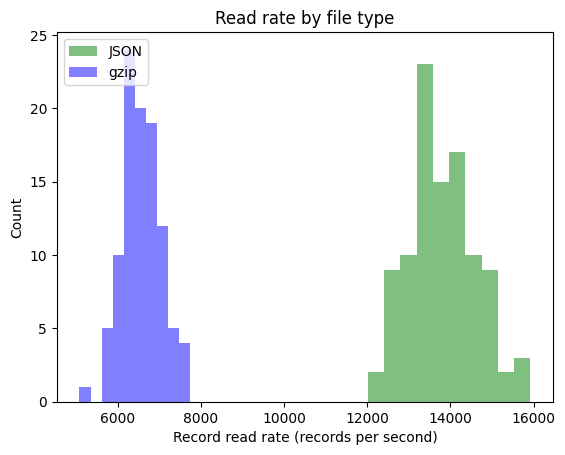

In [7]:
if run_rate_experiments is True:

    plt.title('Read rate by file type')

    plt.hist(
        json_read_rates,
        facecolor = 'green',
        label = 'JSON',
        alpha = 0.5
    )

    plt.hist(
        gzip_read_rates,
        facecolor = 'blue',
        label = 'gzip',
        alpha = 0.5
    )

    plt.legend(loc = 'upper left')
    plt.xlabel(f'Record read rate (records per second)')
    plt.ylabel('Count')
    plt.show()

Reading from the decompressed file is a little less than twice as fast as reading from the gzip archive. No big surprise there. Now let's try reading the whole file - we still don't even know how many records we have!

## 4. Dataset size and read time

### 4.1. Read lines only

In [8]:
%%time

if run_rate_experiments is True:

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:

        # Always skip the first metadata line
        _=next(file)
        
        # Iterate over the lines
        for i, line in enumerate(file):

            # Print a status update every 1000 lines
            if i % 1000 == 0:
                print(f'Read {i} lines', end= '\r')

    print(f'Read {i} lines total\n')

Not terrible, we have 13.8 million records, and it took us about two and a half minutes to visit each one. Let's try it again and see how much we slow down if we load each one to JSON and grab the text.

### 4.2. Load JSON to dictionary

In [ ]:
%%time

if run_rate_experiments is True:

    # Track the number of times we catch KeyError, or 
    # the number of times a record does not have a 'text' key
    keyerror_count=0

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:
        
        # Always skip the first metadata line
        _=next(file)
        
        # Iterate over the lines
        for i, line in enumerate(file):

            record=json.loads(line)

            try:
                text=record['text']

            except KeyError as e:
                keyerror_count+=1

            # Print a status update every 1000 lines
            if i % 1000 == 0:
                print(f'Read {i} lines', end= '\r')

    print(f'Read {i} lines total')
    print(f'{keyerror_count} records don\'t have a text key\n')

Actually reading the JSON into a dictionary increases the total time by a factor of 8, but it still takes less than a half hour to read the whole file. Not terrible if we only need to do this once to parse and batch the text for further processing.

But look at the 'text' key-less record count, it's much more than I thought... Wait, it's exactly half. I bet I know what is going on - only every other line is an article because each one comes with that metadata/header line we saw was the first line in the file. OK, I bet we can speed up a good bit by only looking at every other line.

In [ ]:
%%time

if run_rate_experiments is True:

    # Track the number of times we catch KeyError, or 
    # the number of times a record does not have a 'text' key
    keyerror_count=0

    # Also count the number of texts we were able to successfully extract
    text_count=0

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:
        
        # Iterate over the lines
        for i, line in enumerate(file):

            # Skip even numbered header lines and only
            # attempt a load on odd numbered article lines
            if i % 2 != 0:

                # Load the line to JSON
                record=json.loads(line)

                # Get the text, catching KeyError if the
                # JSON dictionary has no 'text' key
                try:
                    text=record['text']
                    text_count+=1

                # Count key errors
                except KeyError as e:
                    keyerror_count+=1
                
            # Print a status update every 5000 lines
            if i % 5000 == 0:
                print(f'Read {i} lines', end= '\r')

    print(f'Read {i} lines total')
    print(f'Extracted {text_count} article texts')
    print(f'{keyerror_count} records don\'t have a text key\n')

OK, well, it didn't speed up any, which is a little strange. But, at least we are not catching any KeyErrors when we extract the text. Feels cleaner. OK. Time to move on.

## 6. Additional filtering
### 6.1. Wikipedia namespace

After working with the binned text a bit more, I have noticed that we have a fair amount of disambiguation pages and some others that are not strictly 'articles'. Let's see if we can implement a solution to filter these out ahead to time using the 'namespace' tag from the original record.

Here is the list of subject namespaces provided by [Wikipedia](https://en.wikipedia.org/wiki/Wikipedia:What_is_an_article%3F#Namespace)
```text
Subject namespaces
0 	(Main/Article)
2 	User
4 	Wikipedia
6 	File
8 	MediaWiki
10 	Template
12 	Help
14 	Category
100 	Portal
118 	Draft
126 	MOS
710 	TimedText
828 	Module
```

We pretty obviously want the '0' namespace for Main/Article. However, I'm not sure if taking only that tag will filter out disambiguation pages or not. We also have a 'category' tag. Let's see if we can figure out what lives under that:

In [ ]:
%%time

if run_parse_experiments is True:

    # Counter for namespace 0 records
    namespace_zero_count=0

    # Counter for disambiguation pages
    disambiguation_count=0

    # Count redirect pages
    redirects=0

    # Outlines
    outlines=0

    # Lists
    lists=0

    # Indexes
    indexes=0

    # Holder for category values
    categories=[]

    # Track the number of times we catch KeyError, or 
    # the number of times a record does not have a 'text' key
    keyerror_count=0

    # Also count the number of texts we were able to successfully extract
    text_count=0

    # Open the JSON file
    with open(json_data_file_path, 'r') as file:
        
        # Iterate over the lines
        for i, line in enumerate(file):

            # Skip even numbered header lines and only
            # attempt a load on odd numbered article lines
            if i % 2 != 0:

                # Load the line to JSON
                record=json.loads(line)

                # Get the text, catching KeyError if the
                # JSON dictionary has no 'text' key
                try:
                    categories.append(record['category'])
                    text_count+=1
                    
                    if record['namespace'] == 0:
                        namespace_zero_count+=1

                    if 'Disambiguation pages' in record['category']:
                        disambiguation_count+=1

                    if 'Wikipedia redirects' in record['category']:
                        redirects+=1

                    if 'Outline' in record['category']:
                        outlines+=1

                    if 'Lists of topics' in record['category']:
                        lists+=1

                    if 'Wikipedia indexes' in record['categories']:
                        indexes+=1

                # Count key errors
                except KeyError as e:
                    keyerror_count+=1
                
            # Print a status update every 5000 lines
            if i % 5000 == 0:
                print(f'Read {i} lines', end= '\r')

            # Break after 500000 records
            if i == 2000000:
                break

In [ ]:
# if run_parse_experiments is True:
    
#     print(f'Total text records: {text_count}')
#     print(f'Namespace 0 text records: {namespace_zero_count}')
#     print(f'Disambiguation articles: {disambiguation_count}')
#     print(f'Redirect records: {redirects}')
#     print(f'Outline records: {outlines}')
#     print(f'List articles: {lists}')
#     print(f'Index articles: {indexes}')

### 6.2. Mwparserfromhell

Let's try this another way - there is a package available to work with Wikipedia source code: [mwparserfromhell](https://github.com/earwig/mwparserfromhell).

In [ ]:
if run_parse_experiments is True:

    # Convert source string to wikicode
    wikicode=mwparserfromhell.parse(records[1]['source_text'])

    # Strip garbage out of wikicode source
    source_string=wikicode.strip_code(
        normalize=True,
        collapse=True,
        keep_template_params=False
    )


    # Remove extra sections from the end of the document
    source_string=helper_funcs.remove_extra_sections(source_string)

    # Do some string replacements
    source_string=helper_funcs.fix_bad_symbols(source_string)

    # Clean up newlines
    source_string=helper_funcs.clean_newlines(source_string)

    # Get rid of image thumbnail lines and leading spaces
    source_string=helper_funcs.remove_thumbnails(source_string)

In [ ]:
print(wikicode)

In [ ]:
print(source_string)

Ok, this looks much better than anything we were going to come up with in the next few days.

## 7. Conclusion

Reading straight from the gzip archive halves the read rate compared to reading uncompressed JSON. However, even with the compressed data we are looking a less than an hour to process the whole file. Remember, we only need to read from the raw data once to extract the text to batches. I think it's worth the disk space savings and one less additional step in preparing the data to just read straight from the gzip archive.

For cleaning, definitely use mwparserfromhell plus our custom cleaning functions.